In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!unzip "/content/drive/My Drive/pap-smear-pytorch-split"

Archive:  /content/drive/My Drive/pap-smear-pytorch-split.zip
   creating: pap-smear-pytorch-split/test/
   creating: pap-smear-pytorch-split/test/abnormal_dyskeratotic/
  inflating: pap-smear-pytorch-split/test/abnormal_dyskeratotic/002_08.bmp  
  inflating: pap-smear-pytorch-split/test/abnormal_dyskeratotic/003_03.bmp  
  inflating: pap-smear-pytorch-split/test/abnormal_dyskeratotic/003_04.bmp  
  inflating: pap-smear-pytorch-split/test/abnormal_dyskeratotic/003_11.bmp  
  inflating: pap-smear-pytorch-split/test/abnormal_dyskeratotic/007_02.bmp  
  inflating: pap-smear-pytorch-split/test/abnormal_dyskeratotic/007_04.bmp  
  inflating: pap-smear-pytorch-split/test/abnormal_dyskeratotic/008_05.bmp  
  inflating: pap-smear-pytorch-split/test/abnormal_dyskeratotic/009_02.bmp  
  inflating: pap-smear-pytorch-split/test/abnormal_dyskeratotic/010_04.bmp  
  inflating: pap-smear-pytorch-split/test/abnormal_dyskeratotic/010_06.bmp  
  inflating: pap-smear-pytorch-split/test/abnormal_dyskerato

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import copy

In [0]:
def train_model(model, optimizer, loss_metric, train_loader, test_loader, epochs=5):
    model.train()

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    best_test_accuracy = 0.0
    best_model = None

    for epoch in range(epochs):
        model.train()
        
        total_train_loss = 0
        total_train_accuracy = 0
        total = 0
        
        for i, (X,Y) in enumerate(train_loader):
            X, Y = X.cuda(), Y.cuda()            
            P = model(X)
            loss = loss_metric(P, Y)
            optimizer.zero_grad()   
            loss.backward()
            optimizer.step()
            
            total += X.size(0)
            total_train_loss += loss.item()
            predictions = torch.argmax(P, 1)
            total_train_accuracy += (predictions == Y).sum().item()
        
        train_losses.append(total_train_loss / total)
        train_accuracies.append(total_train_accuracy / total)
        
        test_loss, test_accuracy = eval_model(model, loss_metric, test_loader)

        if test_accuracy > best_test_accuracy:
          best_model = copy.deepcopy(model)
          best_test_accuracy = test_accuracy

        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        print('End of Epoch %d: Training loss: %f, Training accuracy: %f, Testing loss: %f, Testing accuracy: %f' %
              (epoch, train_losses[-1], train_accuracies[-1], test_losses[-1], test_accuracies[-1]))
        
    return train_losses, train_accuracies, test_losses, test_accuracies, best_model, best_test_accuracy

In [0]:
def eval_model(model, loss_metric, data_loader):
    model.eval()
    
    total_loss = 0
    total_accuracy = 0
    total = 0
    for i, (X,Y) in enumerate(data_loader):
        X, Y = X.cuda(), Y.cuda()       
        P = model(X)
        loss = loss_metric(P, Y)

        total += X.size(0)
        total_loss += loss.item()
        predictions = torch.argmax(P, 1)
        total_accuracy += (predictions == Y).sum().item()
    
    return total_loss / total, total_accuracy / total

In [6]:
class BasicCNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = torch.nn.Sequential(
        torch.nn.Conv2d(3,32,kernel_size=10, stride = 4, padding = 5),
        torch.nn.BatchNorm2d(32),
        torch.nn.ReLU(inplace = True),
        torch.nn.Conv2d(32,64,kernel_size=10, stride = 4, padding = 5),
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool2d(kernel_size=2,stride = 2),


        torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=10, stride = 4, padding=5),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(inplace=True),
        torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=10, stride = 4, padding=5),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(0.05),

 
    )
    
    # Here the input to conv_final should be a single pixel, as can be obtained
    # by pooling spatially over all pixels. The goal of conv_final is to map
    # from some number of channels to 100, one for each possible class.
    self.conv_final = torch.nn.Sequential(torch.nn.Linear(128,100))
    
  def forward(self, x):
    x = self.conv1(x)
    x = x.view(x.size(0), -1)
    x = self.conv_final(x)
    return x

tb = BasicCNN()
tb.cuda()

BasicCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(10, 10), stride=(4, 4), padding=(5, 5))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(10, 10), stride=(4, 4), padding=(5, 5))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(10, 10), stride=(4, 4), padding=(5, 5))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(10, 10), stride=(4, 4), padding=(5, 5))
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.05, inplace=False)
  )
  (conv_final): Sequential(
    (0): Linear(in_features=128, out_features=100, bias=True)
  )
)

In [0]:
class TruncatedResnet(torch.nn.Module):
  
  def __init__(self, orig_resnet):
    super().__init__()
    self.orig_resnet = orig_resnet
    self.final_linear = torch.nn.Linear(512, 10)
  
  def forward(self, x):
    x = self.orig_resnet.conv1(x)
    x = self.orig_resnet.bn1(x)
    x = self.orig_resnet.relu(x)
    x = self.orig_resnet.maxpool(x)

    x = self.orig_resnet.layer1(x)
    x = self.orig_resnet.layer2(x)
    x = self.orig_resnet.layer3(x)
    x = self.orig_resnet.layer4(x)


    x = self.orig_resnet.avgpool(x)
    x = x.view(x.size(0), -1)

    x = self.final_linear(x)

    return x

resnet = models.resnet18(pretrained=True)
resnet.cuda()
tr = TruncatedResnet(resnet)
tr.cuda()

for parameter in tr.parameters():
  parameter.requires_grad = False

for parameter in tr.orig_resnet.layer3.parameters():
    parameter.requires_grad = True

for parameter in tr.orig_resnet.layer4.parameters():
    parameter.requires_grad = True

for parameter in tr.final_linear.parameters():
    parameter.requires_grad = True



In [0]:
class TruncatedWidenet(torch.nn.Module):
  
  def __init__(self, orig_widenet):
    super().__init__()
    self.orig_widenet = orig_widenet
    self.final_linear = torch.nn.Linear(512, 10)
  
  def forward(self, x):
    x = self.orig_widenet.conv1(x)
    x = self.orig_widenet.bn1(x)
    x = self.orig_widenet.relu(x)
    x = self.orig_widenet.maxpool(x)

    x = self.orig_widenet.layer1(x)
    x = self.orig_widenet.layer2(x)

    x = self.orig_widenet.avgpool(x)
    x = x.view(x.size(0), -1)

    x = self.final_linear(x)

    return x

resnet = models.wide_resnet50_2(pretrained=True)
resnet.cuda()
tw = TruncatedWidenet(resnet)
tw.cuda()

for parameter in tw.parameters():
  parameter.requires_grad = False

for parameter in tw.final_linear.parameters():
    parameter.requires_grad = True

In [0]:
class TruncatedAlexnet(torch.nn.Module):
  
  def __init__(self, orig_alexnet):
    super().__init__()
    self.orig_alexnet = orig_alexnet
    self.final_linear = torch.nn.Linear(4096, 10)

    self.orig_alexnet.classifier[-1] = self.final_linear

  def forward(self, x):
    x = self.orig_alexnet.features(x)
    x = self.orig_alexnet.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.orig_alexnet.classifier(x)
    return x

alexnet = models.alexnet(pretrained=True)
alexnet.cuda()
ta = TruncatedAlexnet(alexnet)
ta.cuda()

for parameter in ta.parameters():
  parameter.requires_grad = False

for parameter in ta.final_linear.parameters():
    parameter.requires_grad = True

In [7]:
TRAIN_MEAN = [0.485, 0.456, 0.406]
TRAIN_STD = [0.229, 0.224, 0.225]

transforms_train = torchvision.transforms.Compose([
    transforms.Resize((300, 300)),
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(TRAIN_MEAN, TRAIN_STD)
  ]
)

transforms_test= torchvision.transforms.Compose([
    transforms.Resize((300, 300)),
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(TRAIN_MEAN, TRAIN_STD)
  ]
)

train_dataset = datasets.ImageFolder('pap-smear-pytorch-split/train', transform=transforms_train)
val_dataset  = datasets.ImageFolder('pap-smear-pytorch-split/val', transform=transforms_test)
test_dataset  = datasets.ImageFolder('pap-smear-pytorch-split/test', transform=transforms_test)

batch = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch, shuffle=True)
val_loader  = torch.utils.data.DataLoader(val_dataset, batch_size=batch, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch, shuffle=False)

model = copy.deepcopy(tb)
model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_metric = nn.CrossEntropyLoss()

train_losses, train_accuracies, test_losses, test_accuracies, best_model, best_test_accuracy = \
    train_model(model, optimizer, loss_metric, train_loader, val_loader, epochs=10)

End of Epoch 0: Training loss: 0.028147, Training accuracy: 0.233519, Testing loss: 0.029405, Testing accuracy: 0.290000
End of Epoch 1: Training loss: 0.016436, Training accuracy: 0.390948, Testing loss: 0.016354, Testing accuracy: 0.466000
End of Epoch 2: Training loss: 0.010128, Training accuracy: 0.603477, Testing loss: 0.009229, Testing accuracy: 0.624000
End of Epoch 3: Training loss: 0.007777, Training accuracy: 0.656281, Testing loss: 0.008015, Testing accuracy: 0.638000
End of Epoch 4: Training loss: 0.006768, Training accuracy: 0.698262, Testing loss: 0.007242, Testing accuracy: 0.668000
End of Epoch 5: Training loss: 0.006115, Training accuracy: 0.716628, Testing loss: 0.006898, Testing accuracy: 0.678000
End of Epoch 6: Training loss: 0.005690, Training accuracy: 0.739915, Testing loss: 0.007365, Testing accuracy: 0.628000
End of Epoch 7: Training loss: 0.005277, Training accuracy: 0.756314, Testing loss: 0.006855, Testing accuracy: 0.668000
End of Epoch 8: Training loss: 0

In [0]:
# keep training on best model if necessary
print(eval_model(best_model, val_loader))
train_losses, train_accuracies, test_losses, test_accuracies, best_model, best_test_accuracy = \
    train_model(best_model, optimizer, train_loader, val_loader, epochs=10)

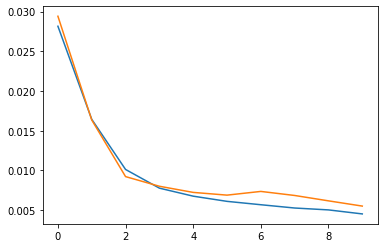

In [8]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(test_losses)

In [9]:
# performance on hold out test set
_, test_acc = eval_model(best_model, loss_metric, test_loader)
print(test_acc)

0.294


In [0]:
model_name = 'cohn_kanade_model_' + str(int(test_acc * 100)) + ".pt"
torch.save(best_model.state_dict(), model_name)